Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# TensorFlow 1.15.2
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1Y2gfhNgbGX7pA0FkA2vbOxdoSmNJVHIK'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1AGW9cRPwBmeJqOo3WXPPcNckrX4jMcIn'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13052
Number of dev sentences:  3263
Number of test sentences:  27625
Number of words in the training dataset:  13860
Number of words in the dev dataset:  6360
Number of words in the test dataset:  21696
Tags in the training dataset: ['B-treatment', 'B-test', 'I-problem', 'I-test', 'O', 'B-problem', 'I-treatment']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-treatment', 'B-test', 'I-problem', 'I-test', 'O', 'B-problem', 'I-treatment']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-treatment', 'B-test', 'I-problem', 'I-test', 'O', 'B-problem', 'I-treatment']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 10707,She,O
1,Sentence: 10707,had,O
2,Sentence: 10707,normal,O
3,Sentence: 10707,comprehension,O
4,Sentence: 10707,.,O
5,Sentence: 7349,Scott,O
6,Sentence: 7349,Robert,O
7,Sentence: 7349,NP,O
8,Sentence: 7349,80-AUM,O
9,Sentence: 7349,2017-06-29,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Last', 'O'),
 ('menstrual', 'O'),
 ('period', 'O'),
 ('2009-02-21', 'O'),
 ('.', 'O')]

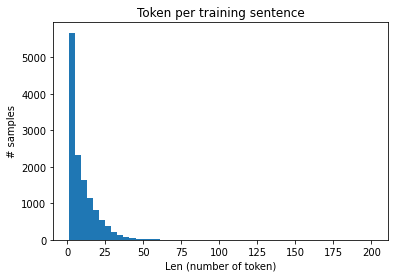

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

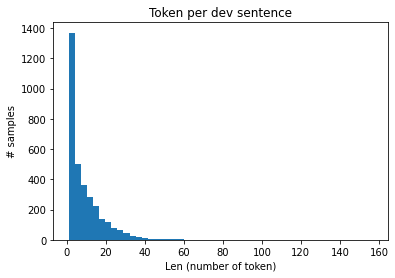

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

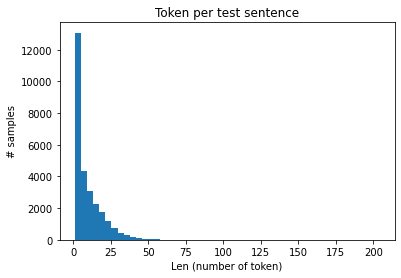

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

6477
2017-01-07
0
O


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.5)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13052
Points in y_train before removal: 13052
Points in X_train before removal: 6526
Points in y_train before removal: 6526


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[4967, 14980, 8645, 27211, 10642, 12573, 26848, 14123, 8352, 12671, 13594, 11032, 13491, 22572, 18311, 21228, 17168, 17174, 12435]
[4, 4, 4, 4, 4, 1, 3, 3, 4, 0, 4, 4, 4, 4, 4, 5, 4, 4, 4]
[749, 15201, 6545, 22805, 5752, 1489, 25581, 11604, 23595, 23167, 24579, 1328, 23345, 12435]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[17360, 2641, 23855]
[4, 4, 4]
6477
0
I-problem
ASHEE
28388
7


In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 1.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 16.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 17.5 MB/s 
     |████████████████████████████████| 596 kB 76.8 MB/s 
     |████████████████████████████████| 6.6 MB 70.9 MB/s 
     |████████████████████████████████| 101 kB 12.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=abed2c9c130a366331d0c1c6f1b6bfe9ed21dac0ec685cd6d8e1b697d00c0085
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[4967, 14980, 8645, 27211, 10642, 12573, 26848, 14123, 8352, 12671, 13594, 11032, 13491, 22572, 18311, 21228, 17168, 17174, 12435]
[4, 4, 4, 4, 4, 1, 3, 3, 4, 0, 4, 4, 4, 4, 4, 5, 4, 4, 4]
[749, 15201, 6545, 22805, 5752, 1489, 25581, 11604, 23595, 23167, 24579, 1328, 23345, 12435]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[17360, 2641, 23855]
[4, 4, 4]
6477
0
I-problem
ASHEE
28388
7


In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

In [ ]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [ ]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [ ]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [' '.join([idx2word[word] for word in sentence]) for sentence in augmented_X_train]
  X_dev_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_dev]
  X_test_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5472992658615112
Training loss per 100 training steps: 0.2576896172791424
Training loss epoch: 0.2558382947509195
Training accuracy epoch: 0.9180404016445288
Validating model...
Validation Loss: 0.17268144974813743
Validation Accuracy: 0.9457623327108621
Training epoch: 2
Training loss per 100 training steps: 0.09694258868694305
Training loss per 100 training steps: 0.07202090736994944
Training loss epoch: 0.07197994323374302
Training accuracy epoch: 0.979463156230234
Validating model...
Validation Loss: 0.14471593641621225
Validation Accuracy: 0.9586348428260192
Training epoch: 3
Training loss per 100 training steps: 0.027650577947497368
Training loss per 100 training steps: 0.03619511823266708
Training loss epoch: 0.036681475659932794
Training accuracy epoch: 0.9874288425047438
Validating model...
Validation Loss: 0.16666445892998108
Validation Accuracy: 0.9570981170245876
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14249752483899808
Validation Accuracy: 0.9578587257226738
Validation duration: 2.1056850000000016 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.79      0.82      1170
        test       0.89      0.87      0.88      2464
   treatment       0.84      0.84      0.84      1244

   micro avg       0.87      0.84      0.86      4878
   macro avg       0.86      0.83      0.85      4878
weighted avg       0.87      0.84      0.86      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6264286041259766
Training loss per 100 training steps: 0.25258289406647777
Training loss epoch: 0.250528451274423
Training accuracy epoch: 0.9243210388994307
Validating model...
Validation Loss: 0.14181587914479712
Validation Accuracy: 0.9580172346716465
Training epoch: 2
Training loss per 100 training steps: 0.06873596459627151
Training loss per 100 training steps: 0.07255953678510862
Training loss epoch: 0.0733698744819883
Training accuracy epoch: 0.9785292141049968
Validating model...
Validation Loss: 0.14192735496908426
Validation Accuracy: 0.9595393713040772
Training epoch: 3
Training loss per 100 training steps: 0.039092060178518295
Training loss per 100 training steps: 0.03484917260328363
Training loss epoch: 0.034678343078578075
Training accuracy epoch: 0.9894301470588235
Validating model...
Validation Loss: 0.16514976686505856
Validation Accuracy: 0.9552647447868036
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1404856385779567
Validation Accuracy: 0.9566333912037037
Validation duration: 2.074618183333333 minutes
F1-score (test): 85.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.75      0.80      1170
        test       0.88      0.87      0.88      2464
   treatment       0.89      0.84      0.86      1244

   micro avg       0.88      0.84      0.86      4878
   macro avg       0.87      0.82      0.85      4878
weighted avg       0.88      0.84      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0686216354370117
Training loss per 100 training steps: 0.26163511210591484
Training loss epoch: 0.26172768379397254
Training accuracy epoch: 0.9172645872865275
Validating model...
Validation Loss: 0.14910155348479748
Validation Accuracy: 0.9546519996887644
Training epoch: 2
Training loss per 100 training steps: 0.034762199968099594
Training loss per 100 training steps: 0.08612987835255295
Training loss epoch: 0.08563569609039262
Training accuracy epoch: 0.9728810879190386
Validating model...
Validation Loss: 0.14801860757756466
Validation Accuracy: 0.9598651960784313
Training epoch: 3
Training loss per 100 training steps: 0.0073192850686609745
Training loss per 100 training steps: 0.03338759003603591
Training loss epoch: 0.03313411780696947
Training accuracy epoch: 0.9911151960784313
Validating model...
Validation Loss: 0.1670511820805533
Validation Accuracy: 0.9598457438530968
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14553819422629508
Validation Accuracy: 0.9588917471205962
Validation duration: 2.077405550000003 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.80      0.83      1170
        test       0.86      0.91      0.89      2464
   treatment       0.82      0.87      0.84      1244

   micro avg       0.85      0.87      0.86      4878
   macro avg       0.85      0.86      0.85      4878
weighted avg       0.85      0.87      0.86      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9806544780731201
Training loss per 100 training steps: 0.2508576419388894
Training loss epoch: 0.24979038463503705
Training accuracy epoch: 0.9223246758380772
Validating model...
Validation Loss: 0.14174688205707306
Validation Accuracy: 0.9583284702769996
Training epoch: 2
Training loss per 100 training steps: 0.05268276482820511
Training loss per 100 training steps: 0.07330047230854041
Training loss epoch: 0.07296106060875543
Training accuracy epoch: 0.9760979996837444
Validating model...
Validation Loss: 0.14900159054234915
Validation Accuracy: 0.9580075085589792
Training epoch: 3
Training loss per 100 training steps: 0.008640672080218792
Training loss per 100 training steps: 0.03638686605736079
Training loss epoch: 0.036616679873915536
Training accuracy epoch: 0.988965646742568
Validating model...
Validation Loss: 0.14058949377424285
Validation Accuracy: 0.9638285869903517
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15124184692588946
Validation Accuracy: 0.9578948947041553
Validation duration: 2.0854041499999996 minutes
F1-score (test): 85.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.80      0.82      1170
        test       0.83      0.92      0.88      2464
   treatment       0.89      0.80      0.84      1244

   micro avg       0.85      0.86      0.86      4878
   macro avg       0.86      0.84      0.85      4878
weighted avg       0.85      0.86      0.85      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.5070831775665283
Training loss per 100 training steps: 0.2763786874342673
Training loss epoch: 0.27558945535736923
Training accuracy epoch: 0.9155795382669197
Validating model...
Validation Loss: 0.13764326628662793
Validation Accuracy: 0.9574044895736072
Training epoch: 2
Training loss per 100 training steps: 0.05789453908801079
Training loss per 100 training steps: 0.07826314221071724
Training loss epoch: 0.0776673530721489
Training accuracy epoch: 0.9779411764705882
Validating model...
Validation Loss: 0.15566442125276023
Validation Accuracy: 0.9558677637721754
Training epoch: 3
Training loss per 100 training steps: 0.015175750479102135
Training loss per 100 training steps: 0.031532539552686235
Training loss epoch: 0.031638266628279406
Training accuracy epoch: 0.9898847643896268
Validating model...
Validation Loss: 0.19107356561146968
Validation Accuracy: 0.9567820183629007
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13333109004371282
Validation Accuracy: 0.9587832401761518
Validation duration: 2.0767467166666695 minutes
F1-score (test): 86.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.94      0.70      0.80      1170
        test       0.89      0.88      0.88      2464
   treatment       0.90      0.85      0.88      1244

   micro avg       0.90      0.83      0.86      4878
   macro avg       0.91      0.81      0.85      4878
weighted avg       0.91      0.83      0.86      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.344062328338623
Training loss per 100 training steps: 0.262694203506897
Training loss epoch: 0.26170669908763144
Training accuracy epoch: 0.9157327245414295
Validating model...
Validation Loss: 0.18019822519272566
Validation Accuracy: 0.9463702147525677
Training epoch: 2
Training loss per 100 training steps: 0.12048400938510895
Training loss per 100 training steps: 0.07966356872959007
Training loss epoch: 0.08021356582678124
Training accuracy epoch: 0.9776249209361164
Validating model...
Validation Loss: 0.15722193117892624
Validation Accuracy: 0.9595442343604108
Training epoch: 3
Training loss per 100 training steps: 0.016070561483502388
Training loss per 100 training steps: 0.035719465730610384
Training loss epoch: 0.03632638845295992
Training accuracy epoch: 0.9891188330170778
Validating model...
Validation Loss: 0.1698406242272433
Validation Accuracy: 0.9580123716153127
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.146006720869789
Validation Accuracy: 0.9624001383242999
Validation duration: 2.080356150000004 minutes
F1-score (test): 87.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.80      0.84      1170
        test       0.92      0.87      0.89      2464
   treatment       0.84      0.89      0.86      1244

   micro avg       0.89      0.86      0.87      4878
   macro avg       0.88      0.85      0.86      4878
weighted avg       0.89      0.86      0.87      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0955326557159424
Training loss per 100 training steps: 0.25123735187151053
Training loss epoch: 0.249504285864532
Training accuracy epoch: 0.9217168722327641
Validating model...
Validation Loss: 0.15263031649531103
Validation Accuracy: 0.9528137643946467
Training epoch: 2
Training loss per 100 training steps: 0.13879041373729706
Training loss per 100 training steps: 0.07675879227808945
Training loss epoch: 0.07614613901002004
Training accuracy epoch: 0.9767156862745098
Validating model...
Validation Loss: 0.14553258249846598
Validation Accuracy: 0.9616839791472145
Training epoch: 3
Training loss per 100 training steps: 0.01068821456283331
Training loss per 100 training steps: 0.031082624830028945
Training loss epoch: 0.03111455693850111
Training accuracy epoch: 0.9911102545857052
Validating model...
Validation Loss: 0.17887569294429803
Validation Accuracy: 0.9595442343604108
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1349391825545657
Validation Accuracy: 0.9610213061766034
Validation duration: 2.075448233333342 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.81      0.84      1170
        test       0.89      0.88      0.89      2464
   treatment       0.89      0.83      0.86      1244

   micro avg       0.89      0.85      0.87      4878
   macro avg       0.89      0.84      0.86      4878
weighted avg       0.89      0.85      0.87      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1023106575012207
Training loss per 100 training steps: 0.2725883689847323
Training loss epoch: 0.271432464613634
Training accuracy epoch: 0.9186333807716636
Validating model...
Validation Loss: 0.1405995374216753
Validation Accuracy: 0.9571078431372549
Training epoch: 2
Training loss per 100 training steps: 0.06602204591035843
Training loss per 100 training steps: 0.07829760416125012
Training loss epoch: 0.07819371527133911
Training accuracy epoch: 0.9760979996837444
Validating model...
Validation Loss: 0.13352158709483988
Validation Accuracy: 0.9604584889511361
Training epoch: 3
Training loss per 100 training steps: 0.0616203211247921
Training loss per 100 training steps: 0.03281061614905069
Training loss epoch: 0.03351205242135763
Training accuracy epoch: 0.988807518975332
Validating model...
Validation Loss: 0.16180043061510385
Validation Accuracy: 0.961085823218176
Training epoch: 4
Training loss per 100 training steps: 0.00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13068692770536505
Validation Accuracy: 0.9591652199074074
Validation duration: 2.093727033333319 minutes
F1-score (test): 86.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.80      0.82      1170
        test       0.90      0.86      0.88      2464
   treatment       0.85      0.86      0.86      1244

   micro avg       0.87      0.85      0.86      4878
   macro avg       0.86      0.84      0.85      4878
weighted avg       0.87      0.85      0.86      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0642900466918945
Training loss per 100 training steps: 0.2596202460071533
Training loss epoch: 0.25807917459557456
Training accuracy epoch: 0.915431293485136
Validating model...
Validation Loss: 0.15116904917008736
Validation Accuracy: 0.9515785480859009
Training epoch: 2
Training loss per 100 training steps: 0.07243241369724274
Training loss per 100 training steps: 0.07774305925474014
Training loss epoch: 0.0782087743921461
Training accuracy epoch: 0.9753271268184693
Validating model...
Validation Loss: 0.15332710913692912
Validation Accuracy: 0.9598603330220976
Training epoch: 3
Training loss per 100 training steps: 0.014017241075634956
Training loss per 100 training steps: 0.03315569349048235
Training loss epoch: 0.0333502707824878
Training accuracy epoch: 0.9895783918406073
Validating model...
Validation Loss: 0.20774333960577554
Validation Accuracy: 0.9527991752256458
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14011120258537293
Validation Accuracy: 0.9548002413617886
Validation duration: 2.082720116666663 minutes
F1-score (test): 84.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.71      0.78      1170
        test       0.91      0.85      0.88      2464
   treatment       0.92      0.77      0.84      1244

   micro avg       0.91      0.79      0.85      4878
   macro avg       0.91      0.78      0.83      4878
weighted avg       0.91      0.79      0.85      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.073638439178467
Training loss per 100 training steps: 0.2754079880985883
Training loss epoch: 0.2745455725520265
Training accuracy epoch: 0.9146604206198609
Validating model...
Validation Loss: 0.14502547918727585
Validation Accuracy: 0.9540295284780578
Training epoch: 2
Training loss per 100 training steps: 0.048184338957071304
Training loss per 100 training steps: 0.06914006563198596
Training loss epoch: 0.06862663487246369
Training accuracy epoch: 0.9774816176470589
Validating model...
Validation Loss: 0.14152771848089554
Validation Accuracy: 0.9580172346716465
Training epoch: 3
Training loss per 100 training steps: 0.07994571328163147
Training loss per 100 training steps: 0.04120034442080351
Training loss epoch: 0.0426898498393997
Training accuracy epoch: 0.9891138915243517
Validating model...
Validation Loss: 0.200281081429007
Validation Accuracy: 0.9595490974167444
Training epoch: 4
Training loss per 100 training steps: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13286373920898228
Validation Accuracy: 0.9593010741305329
Validation duration: 2.076219416666663 minutes
F1-score (test): 86.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.84      0.82      1170
        test       0.91      0.87      0.89      2464
   treatment       0.88      0.85      0.86      1244

   micro avg       0.87      0.86      0.86      4878
   macro avg       0.86      0.85      0.85      4878
weighted avg       0.87      0.86      0.86      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.736918568611145
Training loss per 100 training steps: 0.339573764915366
Training loss per 100 training steps: 0.2664940763793107
Training loss epoch: 0.24376236354822622
Training accuracy epoch: 0.9251143790849673
Validating model...
Validation Loss: 0.1366872096037054
Validation Accuracy: 0.9580071948134092
Training epoch: 2
Training loss per 100 training steps: 0.251456618309021
Training loss per 100 training steps: 0.06398835773625881
Training loss per 100 training steps: 0.06568795112853601
Training loss epoch: 0.07484928441882206
Training accuracy epoch: 0.9764705882352941
Validating model...
Validation Loss: 0.15920512477739476
Validation Accuracy: 0.9546173308032891
Training epoch: 3
Training loss per 100 training steps: 0.02995237335562706
Training loss per 100 training steps: 0.036911144484950247
Training loss per 100 training steps: 0.03303452339793662
Training loss epoch: 0.038380116211277814
Training accuracy epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14432545940750666
Validation Accuracy: 0.9567780671296297
Validation duration: 2.30253585 minutes
F1-score (test): 85.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.75      0.81      1170
        test       0.85      0.90      0.87      2464
   treatment       0.95      0.76      0.85      1244

   micro avg       0.87      0.83      0.85      4878
   macro avg       0.89      0.81      0.84      4878
weighted avg       0.88      0.83      0.85      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8695051670074463
Training loss per 100 training steps: 0.3092555777713804
Training loss per 100 training steps: 0.2470643081475253
Training loss epoch: 0.22727257139688614
Training accuracy epoch: 0.9296486928104575
Validating model...
Validation Loss: 0.13285791773951666
Validation Accuracy: 0.9586298228969007
Training epoch: 2
Training loss per 100 training steps: 0.20169928669929504
Training loss per 100 training steps: 0.07632000278912042
Training loss per 100 training steps: 0.07097739987515506
Training loss epoch: 0.07242805197214087
Training accuracy epoch: 0.9779411764705882
Validating model...
Validation Loss: 0.16077295643980524
Validation Accuracy: 0.9580269607843137
Training epoch: 3
Training loss per 100 training steps: 0.016536647453904152
Training loss per 100 training steps: 0.039293750018079644
Training loss per 100 training steps: 0.04037021544868525
Training loss epoch: 0.04153755166860042
Training accuracy ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14242165162566514
Validation Accuracy: 0.9559622556584363
Validation duration: 2.317926716666667 minutes
F1-score (test): 85.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.79      0.81      1170
        test       0.87      0.90      0.88      2464
   treatment       0.81      0.88      0.84      1244

   micro avg       0.84      0.87      0.85      4878
   macro avg       0.83      0.86      0.84      4878
weighted avg       0.84      0.87      0.85      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.653628349304199
Training loss per 100 training steps: 0.35275452532390555
Training loss per 100 training steps: 0.2664195451588921
Training loss epoch: 0.24485666217903296
Training accuracy epoch: 0.9263398692810457
Validating model...
Validation Loss: 0.1532417217762593
Validation Accuracy: 0.9527988614800759
Training epoch: 2
Training loss per 100 training steps: 0.07657840102910995
Training loss per 100 training steps: 0.07464807932633943
Training loss per 100 training steps: 0.07278985309354331
Training loss epoch: 0.07531918272120404
Training accuracy epoch: 0.9759722222222222
Validating model...
Validation Loss: 0.14820951448443034
Validation Accuracy: 0.9574142156862745
Training epoch: 3
Training loss per 100 training steps: 0.004701179452240467
Training loss per 100 training steps: 0.034308561387859135
Training loss per 100 training steps: 0.04026391130665882
Training loss epoch: 0.03954378030874638
Training accuracy epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15715700939607039
Validation Accuracy: 0.9578792116769548
Validation duration: 2.320515933333339 minutes
F1-score (test): 85.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.75      0.81      1170
        test       0.85      0.91      0.88      2464
   treatment       0.83      0.89      0.86      1244

   micro avg       0.85      0.86      0.86      4878
   macro avg       0.86      0.85      0.85      4878
weighted avg       0.86      0.86      0.86      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.339784622192383
Training loss per 100 training steps: 0.36374333982199136
Training loss per 100 training steps: 0.2812518405992149
Training loss epoch: 0.2582714498992644
Training accuracy epoch: 0.9208251633986928
Validating model...
Validation Loss: 0.1355902232667979
Validation Accuracy: 0.9546568627450981
Training epoch: 2
Training loss per 100 training steps: 0.07817164063453674
Training loss per 100 training steps: 0.07107464784968386
Training loss per 100 training steps: 0.07822686667201939
Training loss epoch: 0.07734627517798513
Training accuracy epoch: 0.9764705882352941
Validating model...
Validation Loss: 0.14477008708990088
Validation Accuracy: 0.9589460784313726
Training epoch: 3
Training loss per 100 training steps: 0.02944590337574482
Training loss per 100 training steps: 0.030072261289449058
Training loss per 100 training steps: 0.036960678793656734
Training loss epoch: 0.039259459603322194
Training accuracy epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13772054922258206
Validation Accuracy: 0.9550419560185185
Validation duration: 2.323567866666667 minutes
F1-score (test): 85.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.77      0.81      1170
        test       0.84      0.91      0.88      2464
   treatment       0.80      0.90      0.85      1244

   micro avg       0.83      0.88      0.85      4878
   macro avg       0.83      0.86      0.84      4878
weighted avg       0.83      0.88      0.85      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1764132976531982
Training loss per 100 training steps: 0.34284585670079337
Training loss per 100 training steps: 0.2614720472324621
Training loss epoch: 0.23855994090657023
Training accuracy epoch: 0.9268137254901961
Validating model...
Validation Loss: 0.15316169293980827
Validation Accuracy: 0.9512867647058824
Training epoch: 2
Training loss per 100 training steps: 0.09662704914808273
Training loss per 100 training steps: 0.07757067846567693
Training loss per 100 training steps: 0.08011358208486356
Training loss epoch: 0.08331854109579295
Training accuracy epoch: 0.9735212418300654
Validating model...
Validation Loss: 0.18080571490595593
Validation Accuracy: 0.9429850569259962
Training epoch: 3
Training loss per 100 training steps: 0.11194121092557907
Training loss per 100 training steps: 0.03756187324490546
Training loss per 100 training steps: 0.038567194457117246
Training loss epoch: 0.038684545349393626
Training accuracy e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14905993734040143
Validation Accuracy: 0.9522207754629629
Validation duration: 2.3606036166666704 minutes
F1-score (test): 83.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.76      0.80      1170
        test       0.81      0.91      0.86      2464
   treatment       0.93      0.74      0.82      1244

   micro avg       0.84      0.83      0.84      4878
   macro avg       0.86      0.80      0.83      4878
weighted avg       0.85      0.83      0.83      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.285524845123291
Training loss per 100 training steps: 0.31278587885127207
Training loss per 100 training steps: 0.2415906393956115
Training loss epoch: 0.22559464386865205
Training accuracy epoch: 0.9284313725490196
Validating model...
Validation Loss: 0.15807109255818466
Validation Accuracy: 0.9525023719165086
Training epoch: 2
Training loss per 100 training steps: 0.012714083306491375
Training loss per 100 training steps: 0.0570652032510774
Training loss per 100 training steps: 0.06874793456445694
Training loss epoch: 0.06745501897279538
Training accuracy epoch: 0.9801470588235294
Validating model...
Validation Loss: 0.14198830868596868
Validation Accuracy: 0.961377292852625
Training epoch: 3
Training loss per 100 training steps: 0.04243474826216698
Training loss per 100 training steps: 0.03607621935189305
Training loss per 100 training steps: 0.03886887132142675
Training loss epoch: 0.03471877308500766
Training accuracy epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14928898298388016
Validation Accuracy: 0.9571759259259259
Validation duration: 2.3312771500000053 minutes
F1-score (test): 85.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.84      0.81      1170
        test       0.83      0.93      0.88      2464
   treatment       0.90      0.84      0.87      1244

   micro avg       0.83      0.88      0.86      4878
   macro avg       0.84      0.87      0.85      4878
weighted avg       0.84      0.88      0.86      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.373702049255371
Training loss per 100 training steps: 0.35054459561142
Training loss per 100 training steps: 0.25359700406804236
Training loss epoch: 0.23569586559509237
Training accuracy epoch: 0.926593137254902
Validating model...
Validation Loss: 0.14621799422756715
Validation Accuracy: 0.9571078431372549
Training epoch: 2
Training loss per 100 training steps: 0.027518074959516525
Training loss per 100 training steps: 0.07409765814790631
Training loss per 100 training steps: 0.08225118991251645
Training loss epoch: 0.08150542201383003
Training accuracy epoch: 0.9743872549019608
Validating model...
Validation Loss: 0.16934686677311273
Validation Accuracy: 0.9512669987349779
Training epoch: 3
Training loss per 100 training steps: 0.043134868144989014
Training loss per 100 training steps: 0.02742080018500622
Training loss per 100 training steps: 0.031192722454648558
Training loss epoch: 0.03366192043074133
Training accuracy epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14724584897824874
Validation Accuracy: 0.9532134130658436
Validation duration: 2.3003695833333344 minutes
F1-score (test): 84.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.92      0.66      0.77      1170
        test       0.86      0.89      0.88      2464
   treatment       0.92      0.76      0.83      1244

   micro avg       0.88      0.80      0.84      4878
   macro avg       0.90      0.77      0.82      4878
weighted avg       0.89      0.80      0.84      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8823301792144775
Training loss per 100 training steps: 0.342401964313323
Training loss per 100 training steps: 0.2671233410877523
Training loss epoch: 0.24506514583732567
Training accuracy epoch: 0.9231535947712418
Validating model...
Validation Loss: 0.1385219337592157
Validation Accuracy: 0.9552399588867806
Training epoch: 2
Training loss per 100 training steps: 0.13042517006397247
Training loss per 100 training steps: 0.071161850922658
Training loss per 100 training steps: 0.07156388103192793
Training loss epoch: 0.07246085644754417
Training accuracy epoch: 0.9786764705882353
Validating model...
Validation Loss: 0.1422564953944518
Validation Accuracy: 0.9574142156862745
Training epoch: 3
Training loss per 100 training steps: 0.003635660046711564
Training loss per 100 training steps: 0.029281731158388908
Training loss per 100 training steps: 0.029890959710577755
Training loss epoch: 0.03482523386403188
Training accuracy epoch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13317603820959684
Validation Accuracy: 0.9591089570473251
Validation duration: 2.3199377333333357 minutes
F1-score (test): 85.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.95      0.69      0.80      1170
        test       0.92      0.86      0.89      2464
   treatment       0.90      0.81      0.85      1244

   micro avg       0.92      0.81      0.86      4878
   macro avg       0.92      0.79      0.85      4878
weighted avg       0.92      0.81      0.86      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2344274520874023
Training loss per 100 training steps: 0.34205329945624463
Training loss per 100 training steps: 0.2630266871636928
Training loss epoch: 0.24224701349203492
Training accuracy epoch: 0.923390522875817
Validating model...
Validation Loss: 0.13519883813226924
Validation Accuracy: 0.9583234503478811
Training epoch: 2
Training loss per 100 training steps: 0.021135905757546425
Training loss per 100 training steps: 0.07783723065150108
Training loss per 100 training steps: 0.07418246944411773
Training loss epoch: 0.07505480905300846
Training accuracy epoch: 0.9763480392156862
Validating model...
Validation Loss: 0.14491330883945064
Validation Accuracy: 0.960171568627451
Training epoch: 3
Training loss per 100 training steps: 0.012104254215955734
Training loss per 100 training steps: 0.034628501623560036
Training loss per 100 training steps: 0.03604582702220922
Training loss epoch: 0.03554149524231131
Training accuracy ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13925417491474137
Validation Accuracy: 0.9555443029835392
Validation duration: 2.3095254166666717 minutes
F1-score (test): 84.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.76      0.83      0.79      1170
        test       0.90      0.85      0.87      2464
   treatment       0.86      0.85      0.85      1244

   micro avg       0.85      0.84      0.85      4878
   macro avg       0.84      0.84      0.84      4878
weighted avg       0.86      0.84      0.85      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 8158
Points in y_train after augmentation: 8158
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9401785135269165
Training loss per 100 training steps: 0.3102267360370053
Training loss per 100 training steps: 0.25066207092607495
Training loss epoch: 0.23116647583596847
Training accuracy epoch: 0.9281781045751634
Validating model...
Validation Loss: 0.19036447534374162
Validation Accuracy: 0.941166587602783
Training epoch: 2
Training loss per 100 training steps: 0.05742259323596954
Training loss per 100 training steps: 0.07980426059952836
Training loss per 100 training steps: 0.07687751472515253
Training loss epoch: 0.08025711576509124
Training accuracy epoch: 0.9754820261437909
Validating model...
Validation Loss: 0.13393916167528824
Validation Accuracy: 0.955862586970272
Training epoch: 3
Training loss per 100 training steps: 0.02013188973069191
Training loss per 100 training steps: 0.032320173962691816
Training loss per 100 training steps: 0.02968158033347471
Training loss epoch: 0.033334856683744446
Training accuracy epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1333230498160076
Validation Accuracy: 0.9605195473251029
Validation duration: 2.3369028166666492 minutes
F1-score (test): 86.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.89      0.75      0.82      1170
        test       0.87      0.90      0.89      2464
   treatment       0.88      0.88      0.88      1244

   micro avg       0.88      0.86      0.87      4878
   macro avg       0.88      0.84      0.86      4878
weighted avg       0.88      0.86      0.87      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8825953006744385
Training loss per 100 training steps: 0.31210801057001153
Training loss per 100 training steps: 0.24675756885637692
Training loss per 100 training steps: 0.22051318635873224
Training loss epoch: 0.21925507941179806
Training accuracy epoch: 0.9319747295469912
Validating model...
Validation Loss: 0.13604410276200404
Validation Accuracy: 0.9577107052498419
Training epoch: 2
Training loss per 100 training steps: 0.03370976820588112
Training loss per 100 training steps: 0.06983543780406402
Training loss per 100 training steps: 0.07171541903415853
Training loss per 100 training steps: 0.07177768723901509
Training loss epoch: 0.07163617690968832
Training accuracy epoch: 0.978236984448952
Validating model...
Validation Loss: 0.14686671612948618
Validation Accuracy: 0.95739444971537
Training epoch: 3
Training loss per 100 training steps: 0.00791121181100607
Training loss per 100 training steps: 0.025902847092054638
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13948088153025578
Validation Accuracy: 0.9578952867798355
Validation duration: 2.3297828499999924 minutes
F1-score (test): 86.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.82      0.81      1170
        test       0.92      0.86      0.89      2464
   treatment       0.93      0.78      0.85      1244

   micro avg       0.89      0.83      0.86      4878
   macro avg       0.88      0.82      0.85      4878
weighted avg       0.89      0.83      0.86      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.145984172821045
Training loss per 100 training steps: 0.31887107770336737
Training loss per 100 training steps: 0.2634711190038801
Training loss per 100 training steps: 0.22414872907968456
Training loss epoch: 0.22236347846151178
Training accuracy epoch: 0.9300449346405228
Validating model...
Validation Loss: 0.17741583838291905
Validation Accuracy: 0.9402474699557243
Training epoch: 2
Training loss per 100 training steps: 0.08129661530256271
Training loss per 100 training steps: 0.07147305684237934
Training loss per 100 training steps: 0.06948457229233797
Training loss per 100 training steps: 0.06803635599291218
Training loss epoch: 0.06838153190515156
Training accuracy epoch: 0.9792687908496732
Validating model...
Validation Loss: 0.13911444384732521
Validation Accuracy: 0.956791587602783
Training epoch: 3
Training loss per 100 training steps: 0.03427371382713318
Training loss per 100 training steps: 0.031224081686370555
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14794332894099946
Validation Accuracy: 0.9564525462962963
Validation duration: 2.3201198666666643 minutes
F1-score (test): 85.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.88      0.81      1170
        test       0.90      0.87      0.88      2464
   treatment       0.83      0.90      0.86      1244

   micro avg       0.84      0.88      0.86      4878
   macro avg       0.82      0.88      0.85      4878
weighted avg       0.85      0.88      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9636012315750122
Training loss per 100 training steps: 0.3445750507387784
Training loss per 100 training steps: 0.26155458216958527
Training loss per 100 training steps: 0.2276426112415436
Training loss epoch: 0.2286087549352422
Training accuracy epoch: 0.9289919990984898
Validating model...
Validation Loss: 0.1264237823357404
Validation Accuracy: 0.9613871758380772
Training epoch: 2
Training loss per 100 training steps: 0.11942697316408157
Training loss per 100 training steps: 0.07566347155065303
Training loss per 100 training steps: 0.0749375816319944
Training loss per 100 training steps: 0.07593920255587297
Training loss epoch: 0.07599919021367003
Training accuracy epoch: 0.9778390522875817
Validating model...
Validation Loss: 0.15085649572303703
Validation Accuracy: 0.9577107052498419
Training epoch: 3
Training loss per 100 training steps: 0.02701777219772339
Training loss per 100 training steps: 0.03883547715596062
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14249958969163276
Validation Accuracy: 0.9570473251028807
Validation duration: 2.370236883333352 minutes
F1-score (test): 85.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.81      0.83      1170
        test       0.82      0.92      0.87      2464
   treatment       0.93      0.81      0.87      1244

   micro avg       0.85      0.87      0.86      4878
   macro avg       0.86      0.85      0.85      4878
weighted avg       0.85      0.87      0.86      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.99105703830719
Training loss per 100 training steps: 0.34206568877590765
Training loss per 100 training steps: 0.2636284606336658
Training loss per 100 training steps: 0.23374696864601088
Training loss epoch: 0.23228956870065112
Training accuracy epoch: 0.9235794173991435
Validating model...
Validation Loss: 0.14986449111179978
Validation Accuracy: 0.9503577640733712
Training epoch: 2
Training loss per 100 training steps: 0.053650662302970886
Training loss per 100 training steps: 0.06956553182767539
Training loss per 100 training steps: 0.06800664500078529
Training loss per 100 training steps: 0.07447908916843257
Training loss epoch: 0.07412494763349993
Training accuracy epoch: 0.9762860604011719
Validating model...
Validation Loss: 0.15457988383622803
Validation Accuracy: 0.9595390575585073
Training epoch: 3
Training loss per 100 training steps: 0.010819368064403534
Training loss per 100 training steps: 0.02954909504428137
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1420342757752493
Validation Accuracy: 0.9558015046296297
Validation duration: 2.334365200000017 minutes
F1-score (test): 85.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.80      0.81      1170
        test       0.87      0.89      0.88      2464
   treatment       0.93      0.76      0.84      1244

   micro avg       0.87      0.83      0.85      4878
   macro avg       0.87      0.82      0.84      4878
weighted avg       0.87      0.83      0.85      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7364704608917236
Training loss per 100 training steps: 0.3448811592810815
Training loss per 100 training steps: 0.2637133454737156
Training loss per 100 training steps: 0.2240514592468689
Training loss epoch: 0.2239450357361313
Training accuracy epoch: 0.9283792540004506
Validating model...
Validation Loss: 0.1487794073262051
Validation Accuracy: 0.9530953510436433
Training epoch: 2
Training loss per 100 training steps: 0.10906517505645752
Training loss per 100 training steps: 0.07347590042656232
Training loss per 100 training steps: 0.06533276950430811
Training loss per 100 training steps: 0.06629730373206379
Training loss epoch: 0.06719439215745071
Training accuracy epoch: 0.9789412891593419
Validating model...
Validation Loss: 0.16466160360997653
Validation Accuracy: 0.9546272137887414
Training epoch: 3
Training loss per 100 training steps: 0.02786666713654995
Training loss per 100 training steps: 0.03210496189393158
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15144623394708442
Validation Accuracy: 0.9500868055555556
Validation duration: 2.3497774499999955 minutes
F1-score (test): 84.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.86      0.75      1170
        test       0.88      0.89      0.88      2464
   treatment       0.88      0.86      0.87      1244

   micro avg       0.82      0.87      0.84      4878
   macro avg       0.81      0.87      0.83      4878
weighted avg       0.83      0.87      0.85      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9866142272949219
Training loss per 100 training steps: 0.3765468020545374
Training loss per 100 training steps: 0.27627330060251315
Training loss per 100 training steps: 0.24328866251357567
Training loss epoch: 0.24126506719762594
Training accuracy epoch: 0.9251007155735859
Validating model...
Validation Loss: 0.13969949825995548
Validation Accuracy: 0.9589361954459203
Training epoch: 2
Training loss per 100 training steps: 0.1108182817697525
Training loss per 100 training steps: 0.0752255737638599
Training loss per 100 training steps: 0.07162056289224038
Training loss per 100 training steps: 0.07338673554003498
Training loss epoch: 0.07303231052203664
Training accuracy epoch: 0.9781242956952896
Validating model...
Validation Loss: 0.1559068331102311
Validation Accuracy: 0.9546370967741936
Training epoch: 3
Training loss per 100 training steps: 0.005351424217224121
Training loss per 100 training steps: 0.02736911981736568
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13611950764607172
Validation Accuracy: 0.9578028549382716
Validation duration: 2.337334949999998 minutes
F1-score (test): 86.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.81      0.82      1170
        test       0.88      0.88      0.88      2464
   treatment       0.86      0.86      0.86      1244

   micro avg       0.86      0.86      0.86      4878
   macro avg       0.85      0.85      0.85      4878
weighted avg       0.86      0.86      0.86      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.020595073699951
Training loss per 100 training steps: 0.32669531445175704
Training loss per 100 training steps: 0.26603116824370415
Training loss per 100 training steps: 0.2279033745759696
Training loss epoch: 0.22648936044729126
Training accuracy epoch: 0.9285940669371197
Validating model...
Validation Loss: 0.1504673621818131
Validation Accuracy: 0.9540441176470589
Training epoch: 2
Training loss per 100 training steps: 0.01014425978064537
Training loss per 100 training steps: 0.07563479109390611
Training loss per 100 training steps: 0.07118238645214217
Training loss per 100 training steps: 0.07232561238779937
Training loss epoch: 0.07221961322467275
Training accuracy epoch: 0.9769199346405228
Validating model...
Validation Loss: 0.1644770605409719
Validation Accuracy: 0.9543406072106262
Training epoch: 3
Training loss per 100 training steps: 0.03075602650642395
Training loss per 100 training steps: 0.03524499849789767
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.155774244845142
Validation Accuracy: 0.9505891525205762
Validation duration: 2.3844189500000237 minutes
F1-score (test): 84.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.71      0.87      0.78      1170
        test       0.84      0.90      0.87      2464
   treatment       0.89      0.83      0.86      1244

   micro avg       0.81      0.88      0.84      4878
   macro avg       0.81      0.87      0.83      4878
weighted avg       0.82      0.88      0.84      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4921178817749023
Training loss per 100 training steps: 0.3566919401435569
Training loss per 100 training steps: 0.27081870078688386
Training loss per 100 training steps: 0.23976811994040428
Training loss epoch: 0.23816604462750499
Training accuracy epoch: 0.9256535947712419
Validating model...
Validation Loss: 0.14433873450273976
Validation Accuracy: 0.953727862112587
Training epoch: 2
Training loss per 100 training steps: 0.11009389907121658
Training loss per 100 training steps: 0.07720585341915709
Training loss per 100 training steps: 0.07660112666100523
Training loss per 100 training steps: 0.07593823947164036
Training loss epoch: 0.07530315201562142
Training accuracy epoch: 0.9756944444444444
Validating model...
Validation Loss: 0.15796641330234706
Validation Accuracy: 0.9512669987349779
Training epoch: 3
Training loss per 100 training steps: 0.012860763818025589
Training loss per 100 training steps: 0.0364420863184248
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14571946027852525
Validation Accuracy: 0.9553674768518519
Validation duration: 2.3182643166666823 minutes
F1-score (test): 85.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.91      0.69      0.79      1170
        test       0.84      0.91      0.87      2464
   treatment       0.89      0.83      0.86      1244

   micro avg       0.87      0.84      0.85      4878
   macro avg       0.88      0.81      0.84      4878
weighted avg       0.87      0.84      0.85      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.311314105987549
Training loss per 100 training steps: 0.3187786284465306
Training loss per 100 training steps: 0.2544786637157795
Training loss per 100 training steps: 0.22137449531076459
Training loss epoch: 0.21972330406101215
Training accuracy epoch: 0.930453431372549
Validating model...
Validation Loss: 0.15159008014654995
Validation Accuracy: 0.9518896268184693
Training epoch: 2
Training loss per 100 training steps: 0.1861923485994339
Training loss per 100 training steps: 0.07953848288680362
Training loss per 100 training steps: 0.07734417554630495
Training loss per 100 training steps: 0.08072085140591667
Training loss epoch: 0.08070077461242262
Training accuracy epoch: 0.9741520171286905
Validating model...
Validation Loss: 0.16091614577910116
Validation Accuracy: 0.9567817046173308
Training epoch: 3
Training loss per 100 training steps: 0.04093551263213158
Training loss per 100 training steps: 0.026058679780839842
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14697064804581547
Validation Accuracy: 0.9531611689814815
Validation duration: 2.3197249333333576 minutes
F1-score (test): 84.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.90      0.73      0.80      1170
        test       0.84      0.90      0.87      2464
   treatment       0.77      0.89      0.83      1244

   micro avg       0.83      0.86      0.84      4878
   macro avg       0.83      0.84      0.83      4878
weighted avg       0.83      0.86      0.84      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2805886268615723
Training loss per 100 training steps: 0.34002591769146445
Training loss per 100 training steps: 0.26936163721763673
Training loss per 100 training steps: 0.23369684428954343
Training loss epoch: 0.23252769125917672
Training accuracy epoch: 0.9281855702050935
Validating model...
Validation Loss: 0.14091094557250686
Validation Accuracy: 0.9558724699557243
Training epoch: 2
Training loss per 100 training steps: 0.028607964515686035
Training loss per 100 training steps: 0.059907333979539866
Training loss per 100 training steps: 0.07192479292294521
Training loss per 100 training steps: 0.07455082553356848
Training loss epoch: 0.07409144595327781
Training accuracy epoch: 0.9750711347757494
Validating model...
Validation Loss: 0.1827630048101841
Validation Accuracy: 0.9469975490196079
Training epoch: 3
Training loss per 100 training steps: 0.11028843373060226
Training loss per 100 training steps: 0.0376582921944826
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14048205778063103
Validation Accuracy: 0.9556929976851852
Validation duration: 2.297312166666658 minutes
F1-score (test): 85.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.74      0.80      1170
        test       0.89      0.89      0.89      2464
   treatment       0.74      0.92      0.82      1244

   micro avg       0.84      0.86      0.85      4878
   macro avg       0.83      0.85      0.84      4878
weighted avg       0.85      0.86      0.85      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0889768600463867
Training loss per 100 training steps: 0.34639736980494884
Training loss per 100 training steps: 0.26030772984194667
Training loss per 100 training steps: 0.2272254924608574
Training loss epoch: 0.2136375361490024
Training accuracy epoch: 0.9325980392156863
Validating model...
Validation Loss: 0.1523711759478365
Validation Accuracy: 0.9534214895635674
Training epoch: 2
Training loss per 100 training steps: 0.04488595947623253
Training loss per 100 training steps: 0.06977649573882175
Training loss per 100 training steps: 0.06056759479068757
Training loss per 100 training steps: 0.05912503975395583
Training loss epoch: 0.06074675998398747
Training accuracy epoch: 0.9810833816285135
Validating model...
Validation Loss: 0.17419371248779855
Validation Accuracy: 0.9515634882985452
Training epoch: 3
Training loss per 100 training steps: 0.01278640702366829
Training loss per 100 training steps: 0.03682586771498277
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1492673735893159
Validation Accuracy: 0.9536112718621399
Validation duration: 2.36044476666666 minutes
F1-score (test): 84.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.74      0.78      1170
        test       0.85      0.89      0.87      2464
   treatment       0.90      0.79      0.84      1244

   micro avg       0.86      0.83      0.84      4878
   macro avg       0.86      0.81      0.83      4878
weighted avg       0.86      0.83      0.84      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9807103872299194
Training loss per 100 training steps: 0.3199340377261143
Training loss per 100 training steps: 0.24968720525873833
Training loss per 100 training steps: 0.22256180717674798
Training loss epoch: 0.20598355321871006
Training accuracy epoch: 0.9331926736211725
Validating model...
Validation Loss: 0.18580882991298886
Validation Accuracy: 0.9485096457938014
Training epoch: 2
Training loss per 100 training steps: 0.2144353836774826
Training loss per 100 training steps: 0.06117264831226577
Training loss per 100 training steps: 0.06721988245288828
Training loss per 100 training steps: 0.06858392293948642
Training loss epoch: 0.06680643072557904
Training accuracy epoch: 0.9816085917125471
Validating model...
Validation Loss: 0.17336509656275204
Validation Accuracy: 0.9549533523086654
Training epoch: 3
Training loss per 100 training steps: 0.01096147857606411
Training loss per 100 training steps: 0.031342346457497096
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1605508138165735
Validation Accuracy: 0.9585503472222222
Validation duration: 2.3623177666666377 minutes
F1-score (test): 86.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.79      0.82      1170
        test       0.85      0.91      0.88      2464
   treatment       0.87      0.85      0.86      1244

   micro avg       0.86      0.87      0.86      4878
   macro avg       0.86      0.85      0.85      4878
weighted avg       0.86      0.87      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.041181802749634
Training loss per 100 training steps: 0.3778532402276403
Training loss per 100 training steps: 0.2887384718589818
Training loss per 100 training steps: 0.2472104230815192
Training loss epoch: 0.23129808779085884
Training accuracy epoch: 0.9247108326089056
Validating model...
Validation Loss: 0.15860510254096166
Validation Accuracy: 0.9543406072106262
Training epoch: 2
Training loss per 100 training steps: 0.04649684578180313
Training loss per 100 training steps: 0.06845068557667408
Training loss per 100 training steps: 0.06726937939352658
Training loss per 100 training steps: 0.06706266750255135
Training loss epoch: 0.06831742670463335
Training accuracy epoch: 0.9788165266106442
Validating model...
Validation Loss: 0.15393346244944076
Validation Accuracy: 0.9561788425047438
Training epoch: 3
Training loss per 100 training steps: 0.013756562024354935
Training loss per 100 training steps: 0.029771434357574227
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16120782806441034
Validation Accuracy: 0.9529803240740741
Validation duration: 2.332252883333361 minutes
F1-score (test): 84.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.82      0.79      1170
        test       0.90      0.85      0.88      2464
   treatment       0.77      0.89      0.82      1244

   micro avg       0.83      0.85      0.84      4878
   macro avg       0.81      0.85      0.83      4878
weighted avg       0.84      0.85      0.84      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6812547445297241
Training loss per 100 training steps: 0.3431489739271969
Training loss per 100 training steps: 0.2670269662338258
Training loss per 100 training steps: 0.23329393218497302
Training loss epoch: 0.22189902515001908
Training accuracy epoch: 0.9319762387713706
Validating model...
Validation Loss: 0.148896977524547
Validation Accuracy: 0.9503281151170145
Training epoch: 2
Training loss per 100 training steps: 0.11454275250434875
Training loss per 100 training steps: 0.08320541093172044
Training loss per 100 training steps: 0.07445144465578887
Training loss per 100 training steps: 0.07453111456834752
Training loss epoch: 0.07465469690789116
Training accuracy epoch: 0.9772318410122669
Validating model...
Validation Loss: 0.16239224995175996
Validation Accuracy: 0.9567817046173308
Training epoch: 3
Training loss per 100 training steps: 0.09255242347717285
Training loss per 100 training steps: 0.03334145809611361
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15226936143234424
Validation Accuracy: 0.9503922325102881
Validation duration: 2.4581560999999663 minutes
F1-score (test): 84.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.69      0.86      0.77      1170
        test       0.86      0.89      0.87      2464
   treatment       0.87      0.85      0.86      1244

   micro avg       0.81      0.87      0.84      4878
   macro avg       0.80      0.87      0.83      4878
weighted avg       0.82      0.87      0.84      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0568695068359375
Training loss per 100 training steps: 0.3717464413678292
Training loss per 100 training steps: 0.28849168228383976
Training loss per 100 training steps: 0.25075899694498593
Training loss epoch: 0.23370236384288437
Training accuracy epoch: 0.9268116729450401
Validating model...
Validation Loss: 0.1344118302541913
Validation Accuracy: 0.9601518026565465
Training epoch: 2
Training loss per 100 training steps: 0.07754463702440262
Training loss per 100 training steps: 0.06969578841489067
Training loss per 100 training steps: 0.07608776603505682
Training loss per 100 training steps: 0.07314071784985632
Training loss epoch: 0.07515055061147108
Training accuracy epoch: 0.9777479957500241
Validating model...
Validation Loss: 0.15491279143401804
Validation Accuracy: 0.9491223908918406
Training epoch: 3
Training loss per 100 training steps: 0.10361190140247345
Training loss per 100 training steps: 0.06594892239686803
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13872778127336427
Validation Accuracy: 0.9554357960390947
Validation duration: 2.370999816666699 minutes
F1-score (test): 84.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.79      0.82      1170
        test       0.82      0.92      0.87      2464
   treatment       0.91      0.76      0.83      1244

   micro avg       0.85      0.85      0.85      4878
   macro avg       0.86      0.82      0.84      4878
weighted avg       0.85      0.85      0.85      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0460898876190186
Training loss per 100 training steps: 0.40323656111365497
Training loss per 100 training steps: 0.3005478861162541
Training loss per 100 training steps: 0.262750112248563
Training loss epoch: 0.2394641381398193
Training accuracy epoch: 0.9245176518883415
Validating model...
Validation Loss: 0.14952415574396796
Validation Accuracy: 0.9540441176470589
Training epoch: 2
Training loss per 100 training steps: 0.03205297142267227
Training loss per 100 training steps: 0.08645178828651251
Training loss per 100 training steps: 0.08163696065700303
Training loss per 100 training steps: 0.08075107325857003
Training loss epoch: 0.07485350502227076
Training accuracy epoch: 0.9754901960784313
Validating model...
Validation Loss: 0.17060590579286308
Validation Accuracy: 0.9604581752055661
Training epoch: 3
Training loss per 100 training steps: 0.061003874987363815
Training loss per 100 training steps: 0.026883799219066
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16379152196572655
Validation Accuracy: 0.9501390496399177
Validation duration: 2.336167749999974 minutes
F1-score (test): 82.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.68      0.84      0.75      1170
        test       0.86      0.88      0.87      2464
   treatment       0.89      0.74      0.81      1244

   micro avg       0.82      0.83      0.82      4878
   macro avg       0.81      0.82      0.81      4878
weighted avg       0.83      0.83      0.83      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9066444635391235
Training loss per 100 training steps: 0.3326516531334065
Training loss per 100 training steps: 0.25325745162530916
Training loss per 100 training steps: 0.2198746095293904
Training loss epoch: 0.20657252884634278
Training accuracy epoch: 0.9358881483627934
Validating model...
Validation Loss: 0.13693073553982757
Validation Accuracy: 0.9598553130929791
Training epoch: 2
Training loss per 100 training steps: 0.05493740737438202
Training loss per 100 training steps: 0.05775485767943711
Training loss per 100 training steps: 0.05900137537635112
Training loss per 100 training steps: 0.060535348847584235
Training loss epoch: 0.06346988340846918
Training accuracy epoch: 0.9807241862262146
Validating model...
Validation Loss: 0.15461806789401225
Validation Accuracy: 0.9580071948134092
Training epoch: 3
Training loss per 100 training steps: 0.04965471848845482
Training loss per 100 training steps: 0.04454609783744384
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13259560568904918
Validation Accuracy: 0.9584418402777778
Validation duration: 2.326042266666627 minutes
F1-score (test): 86.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.82      0.81      1170
        test       0.88      0.89      0.89      2464
   treatment       0.87      0.84      0.86      1244

   micro avg       0.86      0.86      0.86      4878
   macro avg       0.85      0.85      0.85      4878
weighted avg       0.86      0.86      0.86      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0577621459960938
Training loss per 100 training steps: 0.31985843205584746
Training loss per 100 training steps: 0.2430114846083507
Training loss per 100 training steps: 0.2154380763382759
Training loss epoch: 0.20359407819504916
Training accuracy epoch: 0.9355561189993238
Validating model...
Validation Loss: 0.13423183442129955
Validation Accuracy: 0.9555660974067046
Training epoch: 2
Training loss per 100 training steps: 0.04586062952876091
Training loss per 100 training steps: 0.059702690349578265
Training loss per 100 training steps: 0.06190832096252785
Training loss per 100 training steps: 0.06423295340311258
Training loss epoch: 0.0681664527699427
Training accuracy epoch: 0.979954481792717
Validating model...
Validation Loss: 0.17483062881236786
Validation Accuracy: 0.9518896268184693
Training epoch: 3
Training loss per 100 training steps: 0.0827040746808052
Training loss per 100 training steps: 0.0223776367565013
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13795162345707435
Validation Accuracy: 0.9570111561213992
Validation duration: 2.3240377166666195 minutes
F1-score (test): 85.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.81      0.81      1170
        test       0.89      0.86      0.88      2464
   treatment       0.85      0.86      0.86      1244

   micro avg       0.86      0.85      0.85      4878
   macro avg       0.85      0.84      0.85      4878
weighted avg       0.86      0.85      0.85      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6469615697860718
Training loss per 100 training steps: 0.3628171005535244
Training loss per 100 training steps: 0.27349295749778474
Training loss per 100 training steps: 0.23644201532377554
Training loss epoch: 0.22327866386204792
Training accuracy epoch: 0.9306632135612866
Validating model...
Validation Loss: 0.14617077691261382
Validation Accuracy: 0.9561887254901961
Training epoch: 2
Training loss per 100 training steps: 0.02886529080569744
Training loss per 100 training steps: 0.06068993030613897
Training loss per 100 training steps: 0.05896138787948392
Training loss per 100 training steps: 0.05792207977667983
Training loss epoch: 0.059372440461005434
Training accuracy epoch: 0.9829216169226311
Validating model...
Validation Loss: 0.16087112400918177
Validation Accuracy: 0.9555562144212524
Training epoch: 3
Training loss per 100 training steps: 0.011841315776109695
Training loss per 100 training steps: 0.029991237647222852
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14321076833908186
Validation Accuracy: 0.9548410172325104
Validation duration: 2.319400533333343 minutes
F1-score (test): 85.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.76      0.81      1170
        test       0.84      0.91      0.88      2464
   treatment       0.78      0.91      0.84      1244

   micro avg       0.83      0.88      0.85      4878
   macro avg       0.83      0.86      0.84      4878
weighted avg       0.83      0.88      0.85      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 11421
Points in y_train after augmentation: 11421
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3632872104644775
Training loss per 100 training steps: 0.3332275527317335
Training loss per 100 training steps: 0.258210479212341
Training loss per 100 training steps: 0.22566471293420096
Training loss epoch: 0.2129617006536208
Training accuracy epoch: 0.9328515889114266
Validating model...
Validation Loss: 0.15302667012849056
Validation Accuracy: 0.9555364484503479
Training epoch: 2
Training loss per 100 training steps: 0.022007368505001068
Training loss per 100 training steps: 0.05390167278283746
Training loss per 100 training steps: 0.059952472195270196
Training loss per 100 training steps: 0.06437333770876788
Training loss epoch: 0.06567609700663224
Training accuracy epoch: 0.9799454264464407
Validating model...
Validation Loss: 0.16111184541117765
Validation Accuracy: 0.9558527039848198
Training epoch: 3
Training loss per 100 training steps: 0.004961808677762747
Training loss per 100 training steps: 0.030627563399825208
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15317848143900778
Validation Accuracy: 0.9505208333333334
Validation duration: 2.3505278833333554 minutes
F1-score (test): 83.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.80      0.82      1170
        test       0.89      0.86      0.87      2464
   treatment       0.96      0.62      0.75      1244

   micro avg       0.89      0.78      0.83      4878
   macro avg       0.89      0.76      0.81      4878
weighted avg       0.89      0.78      0.83      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.208726644515991
Training loss per 100 training steps: 0.31575754712713827
Training loss per 100 training steps: 0.25127828622524123
Training loss per 100 training steps: 0.21619502728049986
Training loss per 100 training steps: 0.1978346660566003
Training loss epoch: 0.1960501570994144
Training accuracy epoch: 0.9390975140056023
Validating model...
Validation Loss: 0.14573905039943902
Validation Accuracy: 0.9558724699557243
Training epoch: 2
Training loss per 100 training steps: 0.008784808218479156
Training loss per 100 training steps: 0.059670857458126426
Training loss per 100 training steps: 0.05120057816123729
Training loss per 100 training steps: 0.05832969670650391
Training loss per 100 training steps: 0.059486789885935074
Training loss epoch: 0.05914636014081314
Training accuracy epoch: 0.9823069852941176
Validating model...
Validation Loss: 0.17549535634986801
Validation Accuracy: 0.9534214895635674
Training epoch: 3
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14499466431368124
Validation Accuracy: 0.9565047903806585
Validation duration: 2.395033933333252 minutes
F1-score (test): 85.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.86      0.80      1170
        test       0.92      0.86      0.89      2464
   treatment       0.82      0.90      0.86      1244

   micro avg       0.84      0.87      0.86      4878
   macro avg       0.83      0.87      0.85      4878
weighted avg       0.85      0.87      0.86      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1212377548217773
Training loss per 100 training steps: 0.3482142837699687
Training loss per 100 training steps: 0.2697196881847447
Training loss per 100 training steps: 0.23010650983055514
Training loss per 100 training steps: 0.21186003170703116
Training loss epoch: 0.21070650814320235
Training accuracy epoch: 0.9329810049019608
Validating model...
Validation Loss: 0.14474212837533332
Validation Accuracy: 0.9531052340290955
Training epoch: 2
Training loss per 100 training steps: 0.15945740044116974
Training loss per 100 training steps: 0.07420625219508858
Training loss per 100 training steps: 0.06569997474767815
Training loss per 100 training steps: 0.07073269417780943
Training loss per 100 training steps: 0.06802036374255184
Training loss epoch: 0.06747923974377473
Training accuracy epoch: 0.978608630952381
Validating model...
Validation Loss: 0.17887457762160064
Validation Accuracy: 0.9567817046173308
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13025148652862603
Validation Accuracy: 0.9574090149176955
Validation duration: 2.4489171333333313 minutes
F1-score (test): 86.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.78      0.80      1170
        test       0.88      0.90      0.89      2464
   treatment       0.82      0.89      0.86      1244

   micro avg       0.85      0.87      0.86      4878
   macro avg       0.84      0.86      0.85      4878
weighted avg       0.85      0.87      0.86      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.303417682647705
Training loss per 100 training steps: 0.323919995697123
Training loss per 100 training steps: 0.26146535833472784
Training loss per 100 training steps: 0.22213931850148397
Training loss per 100 training steps: 0.20188387902685792
Training loss epoch: 0.20029933814429587
Training accuracy epoch: 0.9358040091036415
Validating model...
Validation Loss: 0.14704610391602138
Validation Accuracy: 0.9561788425047438
Training epoch: 2
Training loss per 100 training steps: 0.036352019757032394
Training loss per 100 training steps: 0.05306224226559706
Training loss per 100 training steps: 0.061128302422278
Training loss per 100 training steps: 0.05967075225666623
Training loss per 100 training steps: 0.062043179223137415
Training loss epoch: 0.06245324234637961
Training accuracy epoch: 0.9819240196078431
Validating model...
Validation Loss: 0.15633153946221093
Validation Accuracy: 0.9586298228969007
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15170708907222702
Validation Accuracy: 0.9537760416666666
Validation duration: 2.3370613166667074 minutes
F1-score (test): 84.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.85      0.78      1170
        test       0.89      0.85      0.87      2464
   treatment       0.91      0.79      0.85      1244

   micro avg       0.85      0.84      0.84      4878
   macro avg       0.84      0.83      0.83      4878
weighted avg       0.86      0.84      0.84      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4284818172454834
Training loss per 100 training steps: 0.33854154655986496
Training loss per 100 training steps: 0.2619029062600871
Training loss per 100 training steps: 0.22948506620845624
Training loss per 100 training steps: 0.20852890701040142
Training loss epoch: 0.2072580705200523
Training accuracy epoch: 0.9342721463585434
Validating model...
Validation Loss: 0.16080623370248312
Validation Accuracy: 0.9482230392156863
Training epoch: 2
Training loss per 100 training steps: 0.036853522062301636
Training loss per 100 training steps: 0.06284487230638687
Training loss per 100 training steps: 0.055210249875533156
Training loss per 100 training steps: 0.06020416350117838
Training loss per 100 training steps: 0.06325562714635072
Training loss epoch: 0.06375257944027372
Training accuracy epoch: 0.9799873074229692
Validating model...
Validation Loss: 0.18975284948543297
Validation Accuracy: 0.9429850569259962
Training epoch: 3
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15356424898210982
Validation Accuracy: 0.9500868055555556
Validation duration: 2.3007954999999733 minutes
F1-score (test): 83.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.80      0.80      1170
        test       0.77      0.92      0.84      2464
   treatment       0.90      0.83      0.86      1244

   micro avg       0.81      0.87      0.84      4878
   macro avg       0.83      0.85      0.84      4878
weighted avg       0.82      0.87      0.84      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.173312187194824
Training loss per 100 training steps: 0.35083373798297185
Training loss per 100 training steps: 0.26735908983840573
Training loss per 100 training steps: 0.22856482119296379
Training loss per 100 training steps: 0.20458212218821012
Training loss epoch: 0.20256448560736745
Training accuracy epoch: 0.9329810049019608
Validating model...
Validation Loss: 0.1650100846491827
Validation Accuracy: 0.949745018975332
Training epoch: 2
Training loss per 100 training steps: 0.04083754122257233
Training loss per 100 training steps: 0.056380710224528785
Training loss per 100 training steps: 0.061451574784601615
Training loss per 100 training steps: 0.05912745478323218
Training loss per 100 training steps: 0.056496714636918036
Training loss epoch: 0.05689355160718026
Training accuracy epoch: 0.9810486694677871
Validating model...
Validation Loss: 0.18887718823651656
Validation Accuracy: 0.9524924889310563
Training epoch: 3
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1552279287923705
Validation Accuracy: 0.9604833783436214
Validation duration: 2.3136782833333807 minutes
F1-score (test): 87.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.88      0.83      1170
        test       0.88      0.90      0.89      2464
   treatment       0.88      0.89      0.89      1244

   micro avg       0.85      0.89      0.87      4878
   macro avg       0.85      0.89      0.87      4878
weighted avg       0.85      0.89      0.87      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1960129737854004
Training loss per 100 training steps: 0.33154256936937276
Training loss per 100 training steps: 0.24882296508002044
Training loss per 100 training steps: 0.21427793274525292
Training loss per 100 training steps: 0.1995073094060575
Training loss epoch: 0.19732814852499822
Training accuracy epoch: 0.9371936274509803
Validating model...
Validation Loss: 0.16278755127032304
Validation Accuracy: 0.9543208412397217
Training epoch: 2
Training loss per 100 training steps: 0.03338158503174782
Training loss per 100 training steps: 0.062301147438696414
Training loss per 100 training steps: 0.05956364780506907
Training loss per 100 training steps: 0.061506884822705485
Training loss per 100 training steps: 0.061497660113981646
Training loss epoch: 0.06129100139985573
Training accuracy epoch: 0.9808517156862745
Validating model...
Validation Loss: 0.1712890892659369
Validation Accuracy: 0.9527889784946236
Training epoch: 3
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14943307917699847
Validation Accuracy: 0.9542623135288066
Validation duration: 2.316564950000005 minutes
F1-score (test): 85.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.82      0.83      1170
        test       0.80      0.93      0.86      2464
   treatment       0.86      0.87      0.87      1244

   micro avg       0.82      0.89      0.85      4878
   macro avg       0.83      0.87      0.85      4878
weighted avg       0.82      0.89      0.85      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.096935987472534
Training loss per 100 training steps: 0.36322796241481703
Training loss per 100 training steps: 0.2848244589007464
Training loss per 100 training steps: 0.24590817908214968
Training loss per 100 training steps: 0.22735827956975732
Training loss epoch: 0.2264974074741807
Training accuracy epoch: 0.9299719887955182
Validating model...
Validation Loss: 0.164133504781799
Validation Accuracy: 0.9442204301075269
Training epoch: 2
Training loss per 100 training steps: 0.03470753878355026
Training loss per 100 training steps: 0.07263307734669214
Training loss per 100 training steps: 0.07231638415725855
Training loss per 100 training steps: 0.07674351096171823
Training loss per 100 training steps: 0.07553008296515357
Training loss epoch: 0.075747348459474
Training accuracy epoch: 0.9778645833333334
Validating model...
Validation Loss: 0.1712495566907284
Validation Accuracy: 0.9558724699557243
Training epoch: 3
Training lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18147872954917452
Validation Accuracy: 0.9398509837962963
Validation duration: 2.297585999999986 minutes
F1-score (test): 81.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.86      0.75      1170
        test       0.77      0.94      0.84      2464
   treatment       0.88      0.75      0.81      1244

   micro avg       0.76      0.87      0.81      4878
   macro avg       0.77      0.85      0.80      4878
weighted avg       0.77      0.87      0.81      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1333119869232178
Training loss per 100 training steps: 0.34693637431258023
Training loss per 100 training steps: 0.2725313164534705
Training loss per 100 training steps: 0.2309158904744046
Training loss per 100 training steps: 0.2102614708762718
Training loss epoch: 0.20937504545744398
Training accuracy epoch: 0.9342721463585434
Validating model...
Validation Loss: 0.1637488730667232
Validation Accuracy: 0.9570979601518027
Training epoch: 2
Training loss per 100 training steps: 0.03475469723343849
Training loss per 100 training steps: 0.05378511615125186
Training loss per 100 training steps: 0.06017793367955074
Training loss per 100 training steps: 0.05957729690646338
Training loss per 100 training steps: 0.05961887926406731
Training loss epoch: 0.05902089176736042
Training accuracy epoch: 0.9820006127450981
Validating model...
Validation Loss: 0.14575051348519458
Validation Accuracy: 0.9586298228969007
Training epoch: 3
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16673376157080014
Validation Accuracy: 0.9561270254629629
Validation duration: 2.274638283333237 minutes
F1-score (test): 85.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.86      0.78      1170
        test       0.89      0.89      0.89      2464
   treatment       0.90      0.84      0.87      1244

   micro avg       0.84      0.87      0.86      4878
   macro avg       0.83      0.86      0.85      4878
weighted avg       0.85      0.87      0.86      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0286312103271484
Training loss per 100 training steps: 0.3374291927655145
Training loss per 100 training steps: 0.26370806377659095
Training loss per 100 training steps: 0.22574944413604334
Training loss per 100 training steps: 0.20766281862127736
Training loss epoch: 0.2055802986290598
Training accuracy epoch: 0.9330575980392157
Validating model...
Validation Loss: 0.13747926309759564
Validation Accuracy: 0.9555660974067046
Training epoch: 2
Training loss per 100 training steps: 0.09864968061447144
Training loss per 100 training steps: 0.06518178848817133
Training loss per 100 training steps: 0.06912955006732796
Training loss per 100 training steps: 0.0679719161483586
Training loss per 100 training steps: 0.06976333694843728
Training loss epoch: 0.07010792093990627
Training accuracy epoch: 0.9778645833333334
Validating model...
Validation Loss: 0.18015165966319138
Validation Accuracy: 0.9509705091714105
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13596559526114207
Validation Accuracy: 0.9569589120370371
Validation duration: 2.3356972500000364 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.82      0.82      1170
        test       0.88      0.88      0.88      2464
   treatment       0.80      0.90      0.85      1244

   micro avg       0.84      0.87      0.86      4878
   macro avg       0.83      0.87      0.85      4878
weighted avg       0.84      0.87      0.86      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 13052
Points in y_train after augmentation: 13052
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0634303092956543
Training loss per 100 training steps: 0.3441353890823551
Training loss per 100 training steps: 0.26696947767904294
Training loss per 100 training steps: 0.23163625067935334
Training loss per 100 training steps: 0.20747877989763258
Training loss epoch: 0.20567908343703797
Training accuracy epoch: 0.9358915441176471
Validating model...
Validation Loss: 0.16312404567896224
Validation Accuracy: 0.9543406072106262
Training epoch: 2
Training loss per 100 training steps: 0.015135444700717926
Training loss per 100 training steps: 0.06443796856882106
Training loss per 100 training steps: 0.06168788945214332
Training loss per 100 training steps: 0.0673127895672852
Training loss per 100 training steps: 0.0654259897069425
Training loss epoch: 0.06609186905666765
Training accuracy epoch: 0.9799873074229692
Validating model...
Validation Loss: 0.18869006721697765
Validation Accuracy: 0.955862586970272
Training epoch: 3
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1544559174714474
Validation Accuracy: 0.9547164351851852
Validation duration: 2.379647983333416 minutes
F1-score (test): 84.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.73      0.85      0.79      1170
        test       0.94      0.82      0.87      2464
   treatment       0.83      0.84      0.84      1244

   micro avg       0.85      0.83      0.84      4878
   macro avg       0.83      0.84      0.83      4878
weighted avg       0.86      0.83      0.84      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1510531902313232
Training loss per 100 training steps: 0.3358585459023419
Training loss per 100 training steps: 0.2605309724918942
Training loss per 100 training steps: 0.23197141531669221
Training loss per 100 training steps: 0.21328314633440792
Training loss per 100 training steps: 0.19248070362620726
Training loss per 100 training steps: 0.17948518585206044
Training loss epoch: 0.17857119612916209
Training accuracy epoch: 0.9431050465057818
Validating model...
Validation Loss: 0.16203898712810055
Validation Accuracy: 0.9546370967741936
Training epoch: 2
Training loss per 100 training steps: 0.01285853236913681
Training loss per 100 training steps: 0.048857635306655475
Training loss per 100 training steps: 0.05485703568588201
Training loss per 100 training steps: 0.05227297214262088
Training loss per 100 training steps: 0.052482353621499236
Training loss per 100 training steps: 0.05143854049735697
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14398041933802436
Validation Accuracy: 0.9565610532407407
Validation duration: 2.4151974000000034 minutes
F1-score (test): 85.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.82      0.80      1170
        test       0.93      0.84      0.88      2464
   treatment       0.84      0.86      0.85      1244

   micro avg       0.87      0.84      0.85      4878
   macro avg       0.85      0.84      0.84      4878
weighted avg       0.87      0.84      0.85      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.38842511177063
Training loss per 100 training steps: 0.36606718374803515
Training loss per 100 training steps: 0.2778516776340814
Training loss per 100 training steps: 0.24057211915024887
Training loss per 100 training steps: 0.2166036916975085
Training loss per 100 training steps: 0.19871917880301043
Training loss per 100 training steps: 0.18554309451973497
Training loss epoch: 0.18379030569461843
Training accuracy epoch: 0.9433092948717948
Validating model...
Validation Loss: 0.1504304603440687
Validation Accuracy: 0.9592524509803921
Training epoch: 2
Training loss per 100 training steps: 0.010151442140340805
Training loss per 100 training steps: 0.05268585377045455
Training loss per 100 training steps: 0.046736238210257006
Training loss per 100 training steps: 0.04757173403533271
Training loss per 100 training steps: 0.04631202316194415
Training loss per 100 training steps: 0.04651796248471439
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1494222859476361
Validation Accuracy: 0.9566132973251029
Validation duration: 2.40568126666667 minutes
F1-score (test): 85.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.73      0.86      0.79      1170
        test       0.88      0.90      0.89      2464
   treatment       0.93      0.77      0.85      1244

   micro avg       0.85      0.86      0.85      4878
   macro avg       0.85      0.84      0.84      4878
weighted avg       0.86      0.86      0.85      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1710751056671143
Training loss per 100 training steps: 0.3591736523563614
Training loss per 100 training steps: 0.2818931359149034
Training loss per 100 training steps: 0.24702454902900017
Training loss per 100 training steps: 0.21843250764259822
Training loss per 100 training steps: 0.2028846567010548
Training loss per 100 training steps: 0.18563259755626954
Training loss epoch: 0.18407105731517626
Training accuracy epoch: 0.941062562845651
Validating model...
Validation Loss: 0.163013681315123
Validation Accuracy: 0.9561788425047438
Training epoch: 2
Training loss per 100 training steps: 0.06074606254696846
Training loss per 100 training steps: 0.05537621909521963
Training loss per 100 training steps: 0.0565982680826851
Training loss per 100 training steps: 0.059279564437394544
Training loss per 100 training steps: 0.06194865232260382
Training loss per 100 training steps: 0.06159693425699712
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15122756918774233
Validation Accuracy: 0.9562717013888888
Validation duration: 2.3672197833333333 minutes
F1-score (test): 84.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.84      0.81      1170
        test       0.95      0.79      0.86      2464
   treatment       0.87      0.85      0.86      1244

   micro avg       0.88      0.81      0.85      4878
   macro avg       0.87      0.82      0.84      4878
weighted avg       0.89      0.81      0.85      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9636863470077515
Training loss per 100 training steps: 0.3407524687302585
Training loss per 100 training steps: 0.26497615738517016
Training loss per 100 training steps: 0.2258825839212492
Training loss per 100 training steps: 0.21062749654560947
Training loss per 100 training steps: 0.19229799396350994
Training loss per 100 training steps: 0.17795930153298226
Training loss epoch: 0.1767506949258116
Training accuracy epoch: 0.9448922197083962
Validating model...
Validation Loss: 0.1754126762332139
Validation Accuracy: 0.945149430740038
Training epoch: 2
Training loss per 100 training steps: 0.0575856938958168
Training loss per 100 training steps: 0.055357952994100824
Training loss per 100 training steps: 0.06090959008095035
Training loss per 100 training steps: 0.057862845240578525
Training loss per 100 training steps: 0.05867763043194312
Training loss per 100 training steps: 0.055148935618511995
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17427632958835468
Validation Accuracy: 0.9536112718621399
Validation duration: 2.389450599999994 minutes
F1-score (test): 84.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.83      0.82      1170
        test       0.89      0.85      0.87      2464
   treatment       0.78      0.88      0.83      1244

   micro avg       0.84      0.85      0.85      4878
   macro avg       0.83      0.85      0.84      4878
weighted avg       0.84      0.85      0.85      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1927597522735596
Training loss per 100 training steps: 0.3330889205162478
Training loss per 100 training steps: 0.2559579810618761
Training loss per 100 training steps: 0.22291195713156878
Training loss per 100 training steps: 0.20270258113230924
Training loss per 100 training steps: 0.18669165127089027
Training loss per 100 training steps: 0.17666760069153856
Training loss epoch: 0.17531531044012666
Training accuracy epoch: 0.9439338235294118
Validating model...
Validation Loss: 0.17927270859032504
Validation Accuracy: 0.9445268026565465
Training epoch: 2
Training loss per 100 training steps: 0.2966929078102112
Training loss per 100 training steps: 0.04952733038283774
Training loss per 100 training steps: 0.06181726754302465
Training loss per 100 training steps: 0.0621267868655709
Training loss per 100 training steps: 0.058330314018051756
Training loss per 100 training steps: 0.05662924442193964
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17226687579817804
Validation Accuracy: 0.9438657407407407
Validation duration: 2.3965423666666537 minutes
F1-score (test): 82.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.69      0.82      0.75      1170
        test       0.79      0.93      0.86      2464
   treatment       0.82      0.87      0.84      1244

   micro avg       0.78      0.88      0.83      4878
   macro avg       0.77      0.87      0.82      4878
weighted avg       0.78      0.88      0.83      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0390100479125977
Training loss per 100 training steps: 0.34487122267779735
Training loss per 100 training steps: 0.2636742016708302
Training loss per 100 training steps: 0.22739742417507294
Training loss per 100 training steps: 0.2074071951837574
Training loss per 100 training steps: 0.19130461540852978
Training loss per 100 training steps: 0.1796499818775372
Training loss epoch: 0.17752153748852578
Training accuracy epoch: 0.9442284125188537
Validating model...
Validation Loss: 0.1467183997270231
Validation Accuracy: 0.9580170777988615
Training epoch: 2
Training loss per 100 training steps: 0.005489998962730169
Training loss per 100 training steps: 0.05725217932468686
Training loss per 100 training steps: 0.05399297126678898
Training loss per 100 training steps: 0.05734771382325852
Training loss per 100 training steps: 0.05776375569092537
Training loss per 100 training steps: 0.054985715818852594
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14311702010389935
Validation Accuracy: 0.9569026491769548
Validation duration: 2.417047716666669 minutes
F1-score (test): 86.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.84      0.79      1170
        test       0.89      0.89      0.89      2464
   treatment       0.88      0.86      0.87      1244

   micro avg       0.85      0.87      0.86      4878
   macro avg       0.84      0.86      0.85      4878
weighted avg       0.86      0.87      0.86      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.088629722595215
Training loss per 100 training steps: 0.33385080110171056
Training loss per 100 training steps: 0.25933975146721994
Training loss per 100 training steps: 0.22047428873079858
Training loss per 100 training steps: 0.19921237258867655
Training loss per 100 training steps: 0.18516909974225668
Training loss per 100 training steps: 0.17312914025644383
Training loss epoch: 0.171628868990666
Training accuracy epoch: 0.9444444444444444
Validating model...
Validation Loss: 0.17495979261401967
Validation Accuracy: 0.953125
Training epoch: 2
Training loss per 100 training steps: 0.08036481589078903
Training loss per 100 training steps: 0.053495705810071216
Training loss per 100 training steps: 0.04468511791514066
Training loss per 100 training steps: 0.04855425057888644
Training loss per 100 training steps: 0.05238733210289117
Training loss per 100 training steps: 0.05233258733880462
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1592184995802031
Validation Accuracy: 0.956396283436214
Validation duration: 2.4396101666666556 minutes
F1-score (test): 85.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.76      0.80      1170
        test       0.89      0.88      0.89      2464
   treatment       0.87      0.84      0.85      1244

   micro avg       0.87      0.84      0.86      4878
   macro avg       0.87      0.83      0.85      4878
weighted avg       0.87      0.84      0.86      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.148143768310547
Training loss per 100 training steps: 0.3290840697170484
Training loss per 100 training steps: 0.25543659053446344
Training loss per 100 training steps: 0.23474596075611529
Training loss per 100 training steps: 0.20693422208814197
Training loss per 100 training steps: 0.19085207226697334
Training loss per 100 training steps: 0.17730704372238906
Training loss epoch: 0.17611552254042703
Training accuracy epoch: 0.9434232026143791
Validating model...
Validation Loss: 0.16401625693976588
Validation Accuracy: 0.9521959993674889
Training epoch: 2
Training loss per 100 training steps: 0.03502234071493149
Training loss per 100 training steps: 0.05439278221168177
Training loss per 100 training steps: 0.053427882894493677
Training loss per 100 training steps: 0.05079870330219302
Training loss per 100 training steps: 0.05214951419070633
Training loss per 100 training steps: 0.051752904859443984
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16222135245186142
Validation Accuracy: 0.9499421296296297
Validation duration: 2.376379016666639 minutes
F1-score (test): 83.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.80      0.81      1170
        test       0.91      0.83      0.87      2464
   treatment       0.71      0.92      0.80      1244

   micro avg       0.82      0.85      0.83      4878
   macro avg       0.81      0.85      0.83      4878
weighted avg       0.84      0.85      0.84      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.284885883331299
Training loss per 100 training steps: 0.3654275207531334
Training loss per 100 training steps: 0.28636684677846247
Training loss per 100 training steps: 0.24477854924295037
Training loss per 100 training steps: 0.21817461539412897
Training loss per 100 training steps: 0.20391705294117377
Training loss per 100 training steps: 0.1863697343505919
Training loss epoch: 0.18601732790314904
Training accuracy epoch: 0.9419424019607843
Validating model...
Validation Loss: 0.16640959523033863
Validation Accuracy: 0.9481933902593296
Training epoch: 2
Training loss per 100 training steps: 0.019158484414219856
Training loss per 100 training steps: 0.04959863629814532
Training loss per 100 training steps: 0.05178840689630994
Training loss per 100 training steps: 0.05044541291875511
Training loss per 100 training steps: 0.05445910605835377
Training loss per 100 training steps: 0.05488928692311257
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14624485163356574
Validation Accuracy: 0.9558015046296297
Validation duration: 2.405309116666649 minutes
F1-score (test): 85.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.89      0.74      0.81      1170
        test       0.84      0.91      0.87      2464
   treatment       0.87      0.88      0.88      1244

   micro avg       0.86      0.86      0.86      4878
   macro avg       0.87      0.84      0.85      4878
weighted avg       0.86      0.86      0.86      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8870939016342163
Training loss per 100 training steps: 0.3220922745911792
Training loss per 100 training steps: 0.25514980652531727
Training loss per 100 training steps: 0.22913031211661242
Training loss per 100 training steps: 0.21364325858150932
Training loss per 100 training steps: 0.19799164537444502
Training loss per 100 training steps: 0.1861794460797295
Training loss epoch: 0.18481943996781422
Training accuracy epoch: 0.9422252073906485
Validating model...
Validation Loss: 0.16165118136981904
Validation Accuracy: 0.9476004111321948
Training epoch: 2
Training loss per 100 training steps: 0.009411745704710484
Training loss per 100 training steps: 0.05023367020375289
Training loss per 100 training steps: 0.05424343228608889
Training loss per 100 training steps: 0.05913042381330025
Training loss per 100 training steps: 0.061665608055693356
Training loss per 100 training steps: 0.06023096146855314
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16171263312787265
Validation Accuracy: 0.9524377893518519
Validation duration: 2.334343599999981 minutes
F1-score (test): 84.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.88      0.81      1170
        test       0.81      0.91      0.86      2464
   treatment       0.88      0.85      0.87      1244

   micro avg       0.81      0.89      0.85      4878
   macro avg       0.81      0.88      0.84      4878
weighted avg       0.81      0.89      0.85      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7654467821121216
Training loss per 100 training steps: 0.37039194150947696
Training loss per 100 training steps: 0.2847066987746057
Training loss per 100 training steps: 0.24836351054309067
Training loss per 100 training steps: 0.2188867276320768
Training loss per 100 training steps: 0.20428047873016572
Training loss per 100 training steps: 0.18956873974663682
Training loss per 100 training steps: 0.17705595018122924
Training loss per 100 training steps: 0.16459751487363677
Training loss per 100 training steps: 0.1582693789353528
Training loss per 100 training steps: 0.1515051042152844
Training loss per 100 training steps: 0.14463022077355878
Training loss per 100 training steps: 0.1388693767043178
Training loss epoch: 0.13740928532339608
Training accuracy epoch: 0.9568014705882353
Validating model...
Validation Loss: 0.18013583827425964
Validation Accuracy: 0.9473039215686274
Training epoch: 2
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18137608751917636
Validation Accuracy: 0.9450392232510288
Validation duration: 2.4130737666666695 minutes
F1-score (test): 81.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.67      0.87      0.76      1170
        test       0.92      0.79      0.85      2464
   treatment       0.79      0.87      0.83      1244

   micro avg       0.81      0.83      0.82      4878
   macro avg       0.79      0.85      0.81      4878
weighted avg       0.83      0.83      0.82      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9437692165374756
Training loss per 100 training steps: 0.34852043638872626
Training loss per 100 training steps: 0.2710668136880024
Training loss per 100 training steps: 0.23239248738843837
Training loss per 100 training steps: 0.20873732773117962
Training loss per 100 training steps: 0.1926841047925209
Training loss per 100 training steps: 0.17716610252534887
Training loss per 100 training steps: 0.1683491161591327
Training loss per 100 training steps: 0.15967712266770043
Training loss per 100 training steps: 0.15350127640347225
Training loss per 100 training steps: 0.14784812888774376
Training loss per 100 training steps: 0.14035825493223594
Training loss per 100 training steps: 0.13461011605683115
Training loss epoch: 0.13355504690359035
Training accuracy epoch: 0.9576439950980392
Validating model...
Validation Loss: 0.17556154321737624
Validation Accuracy: 0.9528087444655281
Training epoch: 2
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16265197580923996
Validation Accuracy: 0.9508825231481481
Validation duration: 2.3825724333333254 minutes
F1-score (test): 83.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.76      0.84      0.79      1170
        test       0.89      0.80      0.84      2464
   treatment       0.87      0.82      0.85      1244

   micro avg       0.85      0.81      0.83      4878
   macro avg       0.84      0.82      0.83      4878
weighted avg       0.86      0.81      0.83      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9085501432418823
Training loss per 100 training steps: 0.3507602187887867
Training loss per 100 training steps: 0.26956574484678125
Training loss per 100 training steps: 0.23099958531688466
Training loss per 100 training steps: 0.20740296557996227
Training loss per 100 training steps: 0.18897746410406754
Training loss per 100 training steps: 0.1760866454649041
Training loss per 100 training steps: 0.16524320535199682
Training loss per 100 training steps: 0.15638265938041138
Training loss per 100 training steps: 0.1482571305492097
Training loss per 100 training steps: 0.14415909655854575
Training loss per 100 training steps: 0.1390700926206969
Training loss per 100 training steps: 0.13343681704247531
Training loss epoch: 0.13199963012006016
Training accuracy epoch: 0.958843954248366
Validating model...
Validation Loss: 0.15323662612639716
Validation Accuracy: 0.9561788425047438
Training epoch: 2
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.13952519470304078
Validation Accuracy: 0.9601779513888888
Validation duration: 2.3892581666666652 minutes
F1-score (test): 86.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.77      0.82      1170
        test       0.86      0.90      0.88      2464
   treatment       0.91      0.85      0.88      1244

   micro avg       0.88      0.86      0.87      4878
   macro avg       0.88      0.84      0.86      4878
weighted avg       0.88      0.86      0.87      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3120615482330322
Training loss per 100 training steps: 0.39591920029113786
Training loss per 100 training steps: 0.300621943186913
Training loss per 100 training steps: 0.25465174016242603
Training loss per 100 training steps: 0.22978660716510324
Training loss per 100 training steps: 0.20613996819695254
Training loss per 100 training steps: 0.18983239651550718
Training loss per 100 training steps: 0.17908252070335068
Training loss per 100 training steps: 0.1707623955804143
Training loss per 100 training steps: 0.16249887231912064
Training loss per 100 training steps: 0.15485153076730643
Training loss per 100 training steps: 0.1500119286995139
Training loss per 100 training steps: 0.14224731082456896
Training loss epoch: 0.14151436592110972
Training accuracy epoch: 0.9568525326797386
Validating model...
Validation Loss: 0.17265421097331188
Validation Accuracy: 0.9546469797596459
Training epoch: 2
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15736433402620337
Validation Accuracy: 0.953125
Validation duration: 2.3728157500000027 minutes
F1-score (test): 84.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.90      0.76      0.82      1170
        test       0.85      0.87      0.86      2464
   treatment       0.78      0.89      0.83      1244

   micro avg       0.84      0.85      0.84      4878
   macro avg       0.84      0.84      0.84      4878
weighted avg       0.84      0.85      0.84      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.315378427505493
Training loss per 100 training steps: 0.3562476382692262
Training loss per 100 training steps: 0.27839552972521353
Training loss per 100 training steps: 0.2400188626740066
Training loss per 100 training steps: 0.21327931542086537
Training loss per 100 training steps: 0.19883936681847894
Training loss per 100 training steps: 0.18649545288877176
Training loss per 100 training steps: 0.1756798284936739
Training loss per 100 training steps: 0.16576115456066756
Training loss per 100 training steps: 0.1588252785441969
Training loss per 100 training steps: 0.1521067150807302
Training loss per 100 training steps: 0.14721947840085467
Training loss per 100 training steps: 0.1409307991820027
Training loss epoch: 0.13964524811203743
Training accuracy epoch: 0.9565563725490196
Validating model...
Validation Loss: 0.18423464029397377
Validation Accuracy: 0.9497252530044276
Training epoch: 2
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17548061394740622
Validation Accuracy: 0.9480251736111112
Validation duration: 2.3921252000000095 minutes
F1-score (test): 82.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.87      0.75      1170
        test       0.84      0.89      0.86      2464
   treatment       0.87      0.79      0.83      1244

   micro avg       0.80      0.86      0.83      4878
   macro avg       0.79      0.85      0.81      4878
weighted avg       0.81      0.86      0.83      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9794503450393677
Training loss per 100 training steps: 0.3544899402001854
Training loss per 100 training steps: 0.2710064463178391
Training loss per 100 training steps: 0.22948028542955354
Training loss per 100 training steps: 0.20571160593425433
Training loss per 100 training steps: 0.1917409302244807
Training loss per 100 training steps: 0.1816242868293808
Training loss per 100 training steps: 0.17070424680653878
Training loss per 100 training steps: 0.16183557761420314
Training loss per 100 training steps: 0.15297588905802548
Training loss per 100 training steps: 0.14539501235731267
Training loss per 100 training steps: 0.1390037659647558
Training loss per 100 training steps: 0.13346065797725365
Training loss epoch: 0.13242557440532313
Training accuracy epoch: 0.9584865196078431
Validating model...
Validation Loss: 0.16678123960189303
Validation Accuracy: 0.9555562144212524
Training epoch: 2
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1590590796939203
Validation Accuracy: 0.9532335069444444
Validation duration: 2.395933316666681 minutes
F1-score (test): 85.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.86      0.79      1170
        test       0.83      0.92      0.87      2464
   treatment       0.84      0.90      0.87      1244

   micro avg       0.81      0.90      0.85      4878
   macro avg       0.80      0.89      0.84      4878
weighted avg       0.81      0.90      0.85      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.113344430923462
Training loss per 100 training steps: 0.3370178398298155
Training loss per 100 training steps: 0.2687857081807816
Training loss per 100 training steps: 0.23345921729440705
Training loss per 100 training steps: 0.20828628370032048
Training loss per 100 training steps: 0.19174403639672
Training loss per 100 training steps: 0.178495100431668
Training loss per 100 training steps: 0.1689654349252454
Training loss per 100 training steps: 0.15858694959429562
Training loss per 100 training steps: 0.15303587948657432
Training loss per 100 training steps: 0.14603769590638085
Training loss per 100 training steps: 0.14067462835394076
Training loss per 100 training steps: 0.13444538417977547
Training loss epoch: 0.1335570728479545
Training accuracy epoch: 0.9589460784313726
Validating model...
Validation Loss: 0.16631400283407785
Validation Accuracy: 0.9524924889310563
Training epoch: 2
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15754641041187117
Validation Accuracy: 0.9537559477880658
Validation duration: 2.403749633333306 minutes
F1-score (test): 84.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.85      0.78      1170
        test       0.89      0.87      0.88      2464
   treatment       0.88      0.82      0.85      1244

   micro avg       0.84      0.85      0.84      4878
   macro avg       0.83      0.84      0.83      4878
weighted avg       0.84      0.85      0.85      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.826410174369812
Training loss per 100 training steps: 0.34893360848326493
Training loss per 100 training steps: 0.2771517159834282
Training loss per 100 training steps: 0.23728014769471958
Training loss per 100 training steps: 0.21628905001428544
Training loss per 100 training steps: 0.19721166154034175
Training loss per 100 training steps: 0.18238832311570713
Training loss per 100 training steps: 0.17219910451251558
Training loss per 100 training steps: 0.16257319353638885
Training loss per 100 training steps: 0.1528897531003434
Training loss per 100 training steps: 0.1464227914054702
Training loss per 100 training steps: 0.13959873258855218
Training loss per 100 training steps: 0.13450653998892317
Training loss epoch: 0.13331002769843384
Training accuracy epoch: 0.9578482434640523
Validating model...
Validation Loss: 0.16606052438888297
Validation Accuracy: 0.9531151170145478
Training epoch: 2
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16382002023615147
Validation Accuracy: 0.9530526620370371
Validation duration: 2.387952283333349 minutes
F1-score (test): 84.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.84      0.81      1170
        test       0.82      0.92      0.86      2464
   treatment       0.87      0.85      0.86      1244

   micro avg       0.82      0.88      0.85      4878
   macro avg       0.82      0.87      0.84      4878
weighted avg       0.82      0.88      0.85      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4162144660949707
Training loss per 100 training steps: 0.3802113490972188
Training loss per 100 training steps: 0.2875908404931574
Training loss per 100 training steps: 0.24444289033322833
Training loss per 100 training steps: 0.21448654160507377
Training loss per 100 training steps: 0.19897088711103517
Training loss per 100 training steps: 0.1818282050545484
Training loss per 100 training steps: 0.16802237700281025
Training loss per 100 training steps: 0.1614103171854953
Training loss per 100 training steps: 0.15387342856009775
Training loss per 100 training steps: 0.14937619981321076
Training loss per 100 training steps: 0.1428107984741933
Training loss per 100 training steps: 0.1376430065845869
Training loss epoch: 0.13650447982517483
Training accuracy epoch: 0.9574397467320261
Validating model...
Validation Loss: 0.17736187193305322
Validation Accuracy: 0.9491223908918406
Training epoch: 2
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1747289985835744
Validation Accuracy: 0.9499782986111112
Validation duration: 2.354794566666654 minutes
F1-score (test): 83.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.77      0.78      1170
        test       0.79      0.92      0.85      2464
   treatment       0.92      0.76      0.83      1244

   micro avg       0.82      0.85      0.83      4878
   macro avg       0.83      0.82      0.82      4878
weighted avg       0.82      0.85      0.83      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 39156
Points in y_train after augmentation: 39156
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9615694284439087
Training loss per 100 training steps: 0.3537227793200181
Training loss per 100 training steps: 0.2696466114353481
Training loss per 100 training steps: 0.23206732532108493
Training loss per 100 training steps: 0.21047998119744837
Training loss per 100 training steps: 0.1912137787345752
Training loss per 100 training steps: 0.17678111253698323
Training loss per 100 training steps: 0.16719831026839452
Training loss per 100 training steps: 0.15907410806139116
Training loss per 100 training steps: 0.15317080280594694
Training loss per 100 training steps: 0.14748693787754252
Training loss per 100 training steps: 0.14086981983407046
Training loss per 100 training steps: 0.13660627750188986
Training loss epoch: 0.1358730194603589
Training accuracy epoch: 0.9570057189542484
Validating model...
Validation Loss: 0.17111573535401156
Validation Accuracy: 0.9485195287792536
Training epoch: 2
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16820108931588712
Validation Accuracy: 0.9499059606481481
Validation duration: 2.359043566666757 minutes
F1-score (test): 83.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.69      0.86      0.77      1170
        test       0.87      0.87      0.87      2464
   treatment       0.84      0.85      0.85      1244

   micro avg       0.81      0.87      0.84      4878
   macro avg       0.80      0.86      0.83      4878
weighted avg       0.82      0.87      0.84      4878

